In [1]:
!pip install transformers[torch]
!pip install accelerate
!pip install emoji
!pip install ipywidgets

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

In [3]:
print(torch.__version__)

2.7.0+cu118


In [4]:
!nvidia-smi

Mon May 19 20:48:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8              4W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import pandas as pd

file_path = r'D:\dataset\Data TA_LABEL.csv'  

df = pd.read_csv(file_path)
df['label_manual'] = df['label_manual'].fillna(0).astype(int)

df.head(10)

,textDisplay,label_manual
0,"Hutan Bojonegoro udah habis di tebang i,,dan d...",0
1,"Jangan khawatir deforestasi!!, kata pak presiden",1
2,"Assalamu&#39;alaikum, izin mengambil salah sat...",1
3,Saya tetap yakin kita terlahir dari nenek moya...,2
4,sekarang rasakan panasnya nggk seperti biasany...,1
5,Sbnr nya hutan milik siapa? Kok berani membaba...,1
6,"demi menyenangkan sahabat jokowi, si haji Is*m...",0
7,Mampus.....Suatu saat kalimantan bakalan gundul,0
8,Kalau orang hidup di kabupaten KKU berdampinga...,0
9,Kalimantan rusak itu akibat ulah pejabat dan o...,0


In [6]:
print(df.shape)

(857, 2)


In [7]:
import re
from bs4 import BeautifulSoup
import emoji

def clean_text(text):
    if isinstance(text, str):
        if re.search(r'<.*?>', text):
            text = BeautifulSoup(text, "html.parser").get_text()

        text = emoji.replace_emoji(text, replace='')
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()
    else:
        text = ""

    return text

df['cleaned_text'] = df['textDisplay'].apply(clean_text)

df = df[df['cleaned_text'] != ""]

print(df[['cleaned_text', 'label_manual']].head(10))

                                        cleaned_text  label_manual
0  Hutan Bojonegoro udah habis di tebang idan di ...             0
1      Jangan khawatir deforestasi kata pak presiden             1
2  Assalamualaikum izin mengambil salah satu klip...             1
3  Saya tetap yakin kita terlahir dari nenek moya...             2
4  sekarang rasakan panasnya nggk seperti biasany...             1
5  Sbnr nya hutan milik siapa Kok berani membabal...             1
6  demi menyenangkan sahabat jokowi si haji Ism j...             0
7         MampusSuatu saat kalimantan bakalan gundul             0
8  Kalau orang hidup di kabupaten KKU berdampinga...             0
9  Kalimantan rusak itu akibat ulah pejabat dan o...             0


In [8]:
output_path = r'D:\dataset\dataset_preprocessing.csv' 
df.to_csv(output_path, index=False)

In [9]:
input_path = r'D:\dataset\dataset_preprocessing.csv'

normalization_dict = {
    'sbnrnya': 'sebenarnya',
    'sbnr': 'sebenarnya',
    'ak': 'aku',
    'gk': 'gak',
    'gak': 'tidak',
    'yg': 'yang',
    'klo': 'kalau',
    'kl': 'kalau',
    'bg': 'banget',
    'gt': 'gitu',
    'gtu': 'gitu',
    'jgn': 'jangan',
    'gpp': 'gapapa',
    'jd': 'jadi',
    'org': 'orang',
    'tak': 'tidak',
    'tgung': 'tanggung',
    'sdh': 'sudah',
    'dah': 'sudah',
    'udh': 'sudah',
    'dh': 'sudah',
    'bgt': 'banget',
    'tmn': 'teman',
    'br': 'baru',
    'lbh': 'lebih',
    'krn': 'karena',
    'SDA': 'sumber daya alam',
    'seblm': 'sebelum',
    'skrg': 'sekarang',
    'skr': 'sekarang',
    'gedhe': 'gede',
    'ngk': 'engga',
    'kn': 'kan',
    'byk': 'banyak',
    'bnyk': 'banyak',
    'gw': 'aku',
    'gue': 'aku',
    'gwk': 'aku',
    'loe': 'kamu',
    'lu': 'kamu',
    'lo': 'kamu',
    'elu': 'kamu',
    'elo': 'kamu',
    'napa': 'kenapa',
    'knp': 'kenapa',
    'mgkn': 'mungkin',
    'gmn': 'gimana',
    'bkn': 'bukan',
    'bs': 'bisa',
    'bisa2': 'bisa-bisa',
    'diaa': 'dia',
    'bgtu': 'begitu',
    'btw': 'ngomong-ngomong',
    'dongg': 'dong',
    'gituu': 'gitu',
    'ntr': 'nanti',
    'msh': 'masih',
    'mauu': 'mau',
    'yakinbgt': 'yakin banget',
    'sampe': 'sampai',
    'mo': 'mau',
    'kek': 'seperti',
    'kyk': 'seperti',
    'ky': 'kayak',
    'ga': 'tidak',
    'enggak': 'tidak',
    'engga': 'tidak',
    'nggak': 'tidak',
    'ngga': 'tidak',
    'tdk': 'tidak',
    'okee': 'oke',
    'okeeee': 'oke',
    'gtw': 'gatau',
    'gatau': 'tidak tahu',
    'gaada': 'tidak ada',
    'gakada': 'tidak ada',
    'gbs': 'tidak bisa',
    'gabisa': 'tidak bisa',
    'gajadi': 'tidak jadi',
    'gapapa': 'tidak apa-apa',
    'gausah': 'tidak usah',
    'udahlah': 'sudah lah',
    'kmn': 'kemana',
    'kmna': 'kemana',
    'sma': 'sama',
    'mls': 'malas',
    'mlas': 'malas',
    'trs2': 'terus-terus',
    'trus2': 'terus-terus',
    'mager': 'malas gerak',
    'drpd': 'daripada',
    'abis': 'habis',
    'mg': 'minggu',
    'biar': 'agar',
    'ampun': 'tidak sanggup',
    'parahh': 'parah',
    'zz': '',
    'zzz': '',
    'wkwk': '',
    'wkwkwk': '',
    'lol': '',
    'hehe': '',
    'haha': '',
    'huhu': '',
    'yaa': 'iya',
    'iyaaa': 'iya',
    'iiya': 'iya',
    'okei': 'oke',
    'okehh': 'oke',
    'heemm': '',
    'tp': 'tapi',
    'dmn': 'dimana',
    'aja': 'saja',
    'dg': 'dengan',
    'dr': 'dari',
    'dpt': 'dapat',
    'karna': 'karena',
    'blm': 'belum',
    'skrng': 'sekarang',
    'ntar': 'nanti',
    'kpn': 'kapan',
    'trs': 'terus',
    'pdhl': 'padahal',
    'kmrn': 'kemarin',
    'km': 'kamu',
    'lg': 'lagi',
    'mknya': 'makanya',
    'trus': 'terus',
    'donk': 'dong',
    'sih': '',
    'deh': '',
    'nya': '',
    'kok': '',
    'hdh': '',
    'cuma': 'hanya',
    'cuman': 'hanya',
    'y': 'ya',
    'thx': 'terima kasih',
    'thnk': 'terima kasih',
    'makasih': 'terima kasih',
    'thanks': 'terima kasih',
    'sm': 'sama',
    'sama2': 'sama-sama',
    'sama2': 'sama-sama',
    'idan': 'dan',
    'pd': 'pada',
    'ya': 'iya',
    'nggk ': 'engga'
}

def normalize_text(text):
    text = text.lower()
    words = text.split()
    normalized_words = [normalization_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

df['normalized_text'] = df['cleaned_text'].apply(normalize_text)
print(df[['cleaned_text', 'normalized_text']].head(10))

output_path = r'D:\dataset\cleaned_text.csv'
df[['normalized_text', 'label_manual']].to_csv(output_path, index=False)

                                        cleaned_text  \
0  Hutan Bojonegoro udah habis di tebang idan di ...   
1      Jangan khawatir deforestasi kata pak presiden   
2  Assalamualaikum izin mengambil salah satu klip...   
3  Saya tetap yakin kita terlahir dari nenek moya...   
4  sekarang rasakan panasnya nggk seperti biasany...   
5  Sbnr nya hutan milik siapa Kok berani membabal...   
6  demi menyenangkan sahabat jokowi si haji Ism j...   
7         MampusSuatu saat kalimantan bakalan gundul   
8  Kalau orang hidup di kabupaten KKU berdampinga...   
9  Kalimantan rusak itu akibat ulah pejabat dan o...   

                                     normalized_text  
0  hutan bojonegoro udah habis di tebang dan di t...  
1      jangan khawatir deforestasi kata pak presiden  
2  assalamualaikum izin mengambil salah satu klip...  
3  saya tetap yakin kita terlahir dari nenek moya...  
4  sekarang rasakan panasnya nggk seperti biasany...  
5  sebenarnya  hutan milik siapa  berani membabal... 

In [10]:
from sklearn.utils import resample
import pandas as pd

input_path = r'D:\dataset\cleaned_text.csv'

X = df['normalized_text']
y = df['label_manual']

df_majority = df[df['label_manual'] == 0]  # Kelas mayoritas (label = 0)
df_minority_1 = df[df['label_manual'] == 1]  # Kelas minoritas 1 (label = 1)
df_minority_2 = df[df['label_manual'] == 2]  # Kelas minoritas 2 (label = 2)

# Oversampling kelas minoritas
df_minority_1_upsampled = resample(df_minority_1,
                                   replace=True,
                                   n_samples=df_majority.shape[0],
                                   random_state=42)

df_minority_2_upsampled = resample(df_minority_2,
                                   replace=True,
                                   n_samples=df_majority.shape[0],
                                   random_state=42)


df_upsampled = pd.concat([df_majority, df_minority_1_upsampled, df_minority_2_upsampled])


print("Original dataset shape:", y.value_counts())
print("Resampled dataset shape:", df_upsampled['label_manual'].value_counts())


output_path = r'D:\dataset\resampled_data.csv'
df_upsampled.to_csv(output_path, index=False)


print(df_upsampled.head(10))


Original dataset shape: label_manual
0    515
1    285
2     47
Name: count, dtype: int64
Resampled dataset shape: label_manual
0    515
1    515
2    515
Name: count, dtype: int64
                                          textDisplay  label_manual  \
0   Hutan Bojonegoro udah habis di tebang i,,dan d...             0   
6   demi menyenangkan sahabat jokowi, si haji Is*m...             0   
7     Mampus.....Suatu saat kalimantan bakalan gundul             0   
8   Kalau orang hidup di kabupaten KKU berdampinga...             0   
9   Kalimantan rusak itu akibat ulah pejabat dan o...             0   
10  Sedih banget, merasa malu jadi manusia. Cuma b...             0   
13  Semoga yg merusak hutan kalimantan mendpat bal...             0   
14  Di luar negeri juga banyak yang gak setuju rai...             0   
16  Hdh manusia serakah GK ada otak mementingkan d...             0   
17  Akibat exploitasi lingkungan berlebih menimbul...             0   

                                     

In [11]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

input_path = r'D:\dataset\resampled_data.csv'
df = pd.read_csv(input_path)

print(df.columns)

print(f"Jumlah nilai null di kolom 'normalized_text': {df['normalized_text'].isnull().sum()}")
print(f"Jumlah baris dengan teks kosong di kolom 'normalized_text': {df['normalized_text'].apply(lambda x: len(str(x).strip()) == 0).sum()}")

df = df[df['normalized_text'].notnull() & (df['normalized_text'].apply(lambda x: len(str(x).strip()) > 0))]

# Tokenisasi, padding, dan truncation
def tokenize_text(text):
    if isinstance(text, str) and text.strip() != "":
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,  
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].flatten()
        return input_ids
    else:
        return []


df['tokenized_text'] = df['normalized_text'].apply(lambda x: tokenize_text(x))


df['tokenized_length'] = df['tokenized_text'].apply(len)
print(f"Panjang tokenisasi:\n{df['tokenized_length'].describe()}")


print(df[['tokenized_text']].head(10))


output_path = r'D:\dataset\dataset_tokenized_indobert.csv'
df.to_csv(output_path, index=False)

print(f"Hasil tokenisasi disimpan di: {output_path}")

Index(['textDisplay', 'label_manual', 'cleaned_text', 'normalized_text'], dtype='object')
Jumlah nilai null di kolom 'normalized_text': 0
Jumlah baris dengan teks kosong di kolom 'normalized_text': 0
Panjang tokenisasi:
count    1545.0
mean      128.0
std         0.0
min       128.0
25%       128.0
50%       128.0
75%       128.0
max       128.0
Name: tokenized_length, dtype: float64
                                      tokenized_text
0  [tensor(3), tensor(3283), tensor(15125), tenso...
1  [tensor(3), tensor(3887), tensor(8536), tensor...
2  [tensor(3), tensor(2528), tensor(13292), tenso...
3  [tensor(3), tensor(2280), tensor(1646), tensor...
4  [tensor(3), tensor(4092), tensor(5236), tensor...
5  [tensor(3), tensor(8647), tensor(10218), tenso...
6  [tensor(3), tensor(6391), tensor(1497), tensor...
7  [tensor(3), tensor(1485), tensor(2315), tensor...
8  [tensor(3), tensor(2112), tensor(31810), tenso...
9  [tensor(3), tensor(2468), tensor(14738), tenso...
Hasil tokenisasi disimpan di: 

In [12]:
def create_attention_mask(input_ids):
    attention_mask = [1 if token_id != tokenizer.pad_token_id else 0 for token_id in input_ids]
    return attention_mask

df['attention_mask'] = df['tokenized_text'].apply(lambda x: create_attention_mask(x))

In [13]:
import torch

def convert_to_tensor(input_ids, attention_mask):
    # Jika input_ids atau attention_mask sudah berupa tensor, gunakan detach().clone()
    input_ids_tensor = input_ids.detach().clone() if isinstance(input_ids, torch.Tensor) else torch.tensor(input_ids)
    attention_mask_tensor = attention_mask.detach().clone() if isinstance(attention_mask, torch.Tensor) else torch.tensor(attention_mask)
    return input_ids_tensor, attention_mask_tensor

df['input_ids_tensor'], df['attention_mask_tensor'] = zip(*df.apply(lambda row: convert_to_tensor(row['tokenized_text'], row['attention_mask']), axis=1))

In [14]:
from sklearn.model_selection import train_test_split


train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)


val_df, test_df = train_test_split(temp_df, test_size=0.33, random_state=42)

print(f"Jumlah data untuk training set: {len(train_df)}")
print(f"Jumlah data untuk validation set: {len(val_df)}")
print(f"Jumlah data untuk test set: {len(test_df)}")


Jumlah data untuk training set: 1081
Jumlah data untuk validation set: 310
Jumlah data untuk test set: 154


In [15]:
# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


train_dataset = SentimentDataset(
    torch.stack(train_df['input_ids_tensor'].tolist()),
    torch.stack(train_df['attention_mask_tensor'].tolist()),
    torch.tensor(train_df['label_manual'].values)
)

val_dataset = SentimentDataset(
    torch.stack(val_df['input_ids_tensor'].tolist()),
    torch.stack(val_df['attention_mask_tensor'].tolist()),
    torch.tensor(val_df['label_manual'].values)
)

test_dataset = SentimentDataset(
    torch.stack(test_df['input_ids_tensor'].tolist()),
    torch.stack(test_df['attention_mask_tensor'].tolist()),
    torch.tensor(test_df['label_manual'].values)
)

In [16]:
class CustomBertClassifier(torch.nn.Module):
    def __init__(self, base_model, num_labels=3, hidden_layer=True):  
        super().__init__()
        self.bert = base_model
        self.num_labels = num_labels
        if hidden_layer:  
            self.hidden = torch.nn.Linear(self.bert.config.hidden_size, 128)
            self.classifier = torch.nn.Linear(128, num_labels)
        else:
            self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        # Mengambil hidden state dari token pertama (CLS token)
        hidden_state = outputs.last_hidden_state[:, 0, :]
        
        if hasattr(self, 'hidden'):
            # Jika menggunakan hidden layer, masukkan ke layer tersembunyi
            hidden_state = self.hidden(hidden_state)
        
        logits = self.classifier(hidden_state)

        # Jika labels disediakan, hitung loss
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss, logits  

        return logits  

# Membekukan seluruh lapisan BERT (backbone)
base_model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

# Model dengan lapisan tersembunyi
model_with_hidden = CustomBertClassifier(base_model=base_model, hidden_layer=True)

# Model tanpa lapisan tersembunyi
model_without_hidden = CustomBertClassifier(base_model=base_model, hidden_layer=False)

In [17]:
# Membekukan seluruh lapisan BERT (backbone)
model = CustomBertClassifier(base_model=AutoModel.from_pretrained("indolem/indobert-base-uncased"), hidden_layer=True)

In [18]:
for param in model.bert.parameters():
    param.requires_grad = False

# Hanya komponen klasifikasi yang akan dilatih (self.classifier atau self.hidden)
for param in model.classifier.parameters():
    param.requires_grad = True

if hasattr(model, 'hidden'):
    for param in model.hidden.parameters():
        param.requires_grad = True
else:
    pass

In [19]:
def log_metrics_to_csv(metrics, epoch, filename='metrics_log.csv'):
    file_exists = False
    try:
        with open(filename, 'r') as file:
            file_exists = True
    except FileNotFoundError:
        pass

    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(['epoch', 'accuracy', 'precision', 'recall', 'f1'])

        writer.writerow([epoch, metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1']])

In [20]:
# Menghitung distribusi label_manual
label_counts = df['label_manual'].value_counts()
print(label_counts)

label_manual
0    515
1    515
2    515
Name: count, dtype: int64


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    metrics = {
        'accuracy': accuracy_score(labels, preds),  # Akurasi
        'precision': precision_score(labels, preds, average='weighted'),  # Precision
        'recall': recall_score(labels, preds, average='weighted'),  # Recall
        'f1': f1_score(labels, preds, average='weighted')  # F1 score
    }
    return metrics

def evaluate_validation_metrics(trainer):
    eval_results = trainer.evaluate()
    eval_metrics = {
        'validation_accuracy': eval_results.get("eval_accuracy", None),
        'validation_precision': eval_results.get("eval_precision", None),
        'validation_recall': eval_results.get("eval_recall", None),
        'validation_f1': eval_results.get("eval_f1", None),
    }
    return eval_metrics

In [22]:
import time
import pandas as pd
import numpy as np
import torch.nn as nn
from sklearn.metrics import f1_score
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from torch.optim import AdamW

class TimingCallback(TrainerCallback):
    def __init__(self, trainer):
        self.trainer = trainer

    def on_epoch_begin(self, args, state, control, **kwargs):
        self.start_time = time.time()

    def on_epoch_end(self, args, state, control, **kwargs):
        training_time = time.time() - self.start_time

        # Waktu validasi
        val_start_time = time.time()
        eval_results = self.trainer.evaluate()
        val_end_time = time.time()
        val_time = val_end_time - val_start_time

        training_loss = None
        if len(self.trainer.state.log_history) > 0 and "loss" in self.trainer.state.log_history[-1]:
            training_loss = self.trainer.state.log_history[-1]["loss"]

        
        train_predictions = self.trainer.predict(train_dataset).predictions
        train_labels = self.trainer.predict(train_dataset).label_ids
        train_preds = np.argmax(train_predictions, axis=1)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')

        epoch_results = {
            "Epoch": state.epoch,
            "Training Loss": training_loss,
            "Validation Loss": eval_results["eval_loss"] if "eval_loss" in eval_results else None,
            "Training F1": train_f1,
            "Validation Accuracy": eval_results["eval_accuracy"] if "eval_accuracy" in eval_results else None,
            "Validation Precision": eval_results["eval_precision"] if "eval_precision" in eval_results else None,
            "Validation Recall": eval_results["eval_recall"] if "eval_recall" in eval_results else None,
            "Validation F1": eval_results["eval_f1"] if "eval_f1" in eval_results else None,
            "Training Time (s)": training_time,
            "Validation Time (s)": val_time
        }
        epoch_results_list.append(epoch_results)

# Model dengan lapisan tersembunyi
model_with_hidden = CustomBertClassifier(base_model=base_model, hidden_layer=True)

# Model tanpa lapisan tersembunyi
model_without_hidden = CustomBertClassifier(base_model=base_model, hidden_layer=False)

learning_rates = [5e-5]
epochs = [50]

epoch_results_list = []

# Waktu mulai pelatihan
start_time = time.time()  

# Pengaturan untuk training arguments
training_args = TrainingArguments(
    output_dir='./results',  
    num_train_epochs=epochs[0], 
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    learning_rate=learning_rates[0],
    logging_dir='./logs',
    logging_steps=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    lr_scheduler_type="linear",
)

# Optimizer untuk masing-masing model
optimizer_with_hidden = AdamW(model_with_hidden.parameters(), lr=learning_rates[0])
optimizer_without_hidden = AdamW(model_without_hidden.parameters(), lr=learning_rates[0])

timing_callback = TimingCallback(trainer=None)

# Trainer untuk model dengan lapisan tersembunyi
trainer_with_hidden = Trainer(
    model=model_with_hidden,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer_with_hidden, None),
    callbacks=[timing_callback]
)
timing_callback.trainer = trainer_with_hidden 

# Trainer untuk model tanpa lapisan tersembunyi
trainer_without_hidden = Trainer(
    model=model_without_hidden,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer_without_hidden, None),
    callbacks=[timing_callback]
)
timing_callback.trainer = trainer_without_hidden

In [23]:
#Training dengan lapisan tersembunyi
for lr in learning_rates:
    for epoch in epochs:
        print(f"Training with learning rate: {lr}, epochs: {epoch} with Hidden Layer")

        
        training_args.output_dir = f'./results_with_hidden_lr_{lr}_epochs_{epoch}'
        
        
        trainer_with_hidden.train()

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training with learning rate {lr} and {epoch} epochs took {training_time:.2f} seconds.")
        
        eval_results_with_hidden = trainer_with_hidden.evaluate()

        print("Model dengan lapisan tersembunyi:")
        print(eval_results_with_hidden)

        df_results_with_hidden = pd.DataFrame(epoch_results_list)
        csv_output_path_with_hidden = './training_results_with_hidden.csv'
        df_results_with_hidden.to_csv(csv_output_path_with_hidden, index=False)
        print(f"Hasil pelatihan disimpan dalam file: {csv_output_path_with_hidden}")


Training with learning rate: 5e-05, epochs: 50 with Hidden Layer


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.106600,1.026529,0.477419,0.480724,0.477419,0.422275
2,0.820700,0.892300,0.612903,0.602225,0.612903,0.597502
3,1.044100,0.774574,0.641935,0.671318,0.641935,0.614046
4,0.442400,0.504703,0.770968,0.780789,0.770968,0.760594
5,0.588500,0.482400,0.809677,0.827245,0.809677,0.800885
6,0.351300,0.350296,0.832258,0.829311,0.832258,0.830376
7,0.509500,0.491025,0.880645,0.891248,0.880645,0.878855
8,0.203200,0.922283,0.800000,0.802283,0.800000,0.792779
9,0.005000,0.961722,0.835484,0.835000,0.835484,0.830875
10,0.000300,0.884948,0.864516,0.864095,0.864516,0.862689


Training with learning rate 5e-05 and 50 epochs took 4321.61 seconds.


Model dengan lapisan tersembunyi:
{'eval_loss': 0.350295752286911, 'eval_accuracy': 0.832258064516129, 'eval_precision': 0.8293107877785297, 'eval_recall': 0.832258064516129, 'eval_f1': 0.8303763731190924, 'eval_runtime': 4.5682, 'eval_samples_per_second': 67.86, 'eval_steps_per_second': 2.189, 'epoch': 50.0}
Hasil pelatihan disimpan dalam file: ./training_results_with_hidden.csv


In [24]:
#Training tanpa lapisan tersembunyi
for lr in learning_rates:
    for epoch in epochs:
        print(f"Training with learning rate: {lr}, epochs: {epoch} without Hidden Layer")

        # Update output_dir untuk model tanpa lapisan tersembunyi
        training_args.output_dir = f'./results_without_hidden_lr_{lr}_epochs_{epoch}'
        
        # Train model tanpa lapisan tersembunyi
        trainer_without_hidden.train()

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training with learning rate {lr} and {epoch} epochs took {training_time:.2f} seconds.")
        
        eval_results_without_hidden = trainer_without_hidden.evaluate()

        print("Model tanpa lapisan tersembunyi:")
        print(eval_results_without_hidden)

        df_results_without_hidden = pd.DataFrame(epoch_results_list)
        csv_output_path_without_hidden = './training_results_without_hidden.csv'
        df_results_without_hidden.to_csv(csv_output_path_without_hidden, index=False)
        print(f"Hasil pelatihan model tanpa lapisan tersembunyi disimpan dalam file: {csv_output_path_without_hidden}")

Training with learning rate: 5e-05, epochs: 50 without Hidden Layer


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,0.454300,0.471743,0.000000,0.822581,0.817729,0.822581,0.819535
2,0.011900,0.659897,0.000000,0.825806,0.828347,0.825806,0.822599
3,0.272600,0.917834,0.000000,0.793548,0.787755,0.793548,0.783178
4,0.000900,0.747611,0.000000,0.845161,0.842628,0.845161,0.842482
5,0.000200,0.871259,0.000000,0.864516,0.862591,0.864516,0.863336
6,0.632400,1.131006,0.000000,0.822581,0.818624,0.822581,0.817350
7,0.008400,1.051175,0.000000,0.822581,0.818577,0.822581,0.816042
8,0.000800,1.008320,0.000000,0.832258,0.834728,0.832258,0.827101
9,0.000300,0.788131,0.000000,0.861290,0.860961,0.861290,0.860850
10,0.001300,0.805188,0.000000,0.880645,0.879909,0.880645,0.879756


Training with learning rate 5e-05 and 50 epochs took 8424.39 seconds.


Model tanpa lapisan tersembunyi:
{'eval_loss': 1.374197244644165, 'eval_model_preparation_time': 0.0, 'eval_accuracy': 0.867741935483871, 'eval_precision': 0.8671126680614346, 'eval_recall': 0.867741935483871, 'eval_f1': 0.8669010038036762, 'eval_runtime': 4.5266, 'eval_samples_per_second': 68.485, 'eval_steps_per_second': 2.209, 'epoch': 50.0}
Hasil pelatihan model tanpa lapisan tersembunyi disimpan dalam file: ./training_results_without_hidden.csv


In [25]:
# Evaluasi model dengan lapisan tersembunyi
eval_results_with_hidden = trainer_with_hidden.evaluate()

# Evaluasi model tanpa lapisan tersembunyi
eval_results_without_hidden = trainer_without_hidden.evaluate()


print("Model dengan lapisan tersembunyi:")
print(eval_results_with_hidden)

print("Model tanpa lapisan tersembunyi:")
print(eval_results_without_hidden)

results = {
    'Metric': ['accuracy', 'precision', 'recall', 'f1'],
    'Dengan Lapisan Tersembunyi': [
        eval_results_with_hidden.get('eval_accuracy', None),
        eval_results_with_hidden.get('eval_precision', None),
        eval_results_with_hidden.get('eval_recall', None),
        eval_results_with_hidden.get('eval_f1', None),
    ],
    'Tanpa Lapisan Tersembunyi': [
        eval_results_without_hidden.get('eval_accuracy', None),
        eval_results_without_hidden.get('eval_precision', None),
        eval_results_without_hidden.get('eval_recall', None),
        eval_results_without_hidden.get('eval_f1', None),
    ]
}


df_results = pd.DataFrame(results)

csv_output_path = './model_comparison_results.csv'
df_results.to_csv(csv_output_path, index=False)

print(f"Hasil evaluasi disimpan dalam file: {csv_output_path}")

Model dengan lapisan tersembunyi:
{'eval_loss': 0.4588060975074768, 'eval_accuracy': 0.8580645161290322, 'eval_precision': 0.8572897987742164, 'eval_recall': 0.8580645161290322, 'eval_f1': 0.8566143482388872, 'eval_runtime': 4.4836, 'eval_samples_per_second': 69.142, 'eval_steps_per_second': 2.23, 'epoch': 50.0}
Model tanpa lapisan tersembunyi:
{'eval_loss': 1.374197244644165, 'eval_model_preparation_time': 0.0, 'eval_accuracy': 0.867741935483871, 'eval_precision': 0.8671126680614346, 'eval_recall': 0.867741935483871, 'eval_f1': 0.8669010038036762, 'eval_runtime': 4.4936, 'eval_samples_per_second': 68.987, 'eval_steps_per_second': 2.225, 'epoch': 50.0}
Hasil evaluasi disimpan dalam file: ./model_comparison_results.csv


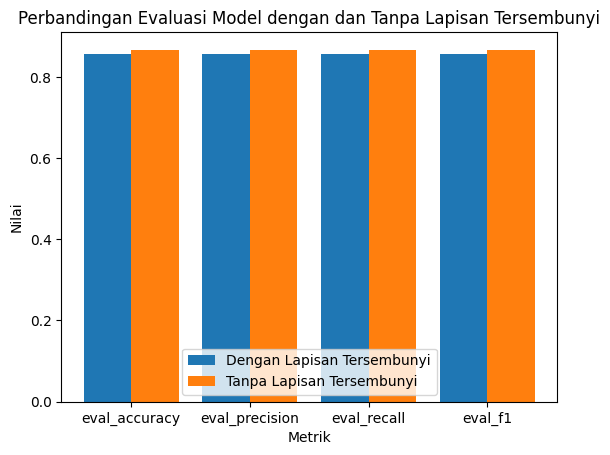

In [26]:
import matplotlib.pyplot as plt

metrics = ['eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1']

hidden_metrics = [eval_results_with_hidden.get(metric, None) for metric in metrics]
no_hidden_metrics = [eval_results_without_hidden.get(metric, None) for metric in metrics]

x_labels = metrics
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots()

# Membuat bar plot perbandingan
ax.bar(x_pos - 0.2, hidden_metrics, 0.4, label='Dengan Lapisan Tersembunyi')
ax.bar(x_pos + 0.2, no_hidden_metrics, 0.4, label='Tanpa Lapisan Tersembunyi')

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Metrik')
ax.set_ylabel('Nilai')
ax.legend()

plt.title("Perbandingan Evaluasi Model dengan dan Tanpa Lapisan Tersembunyi")
plt.show()

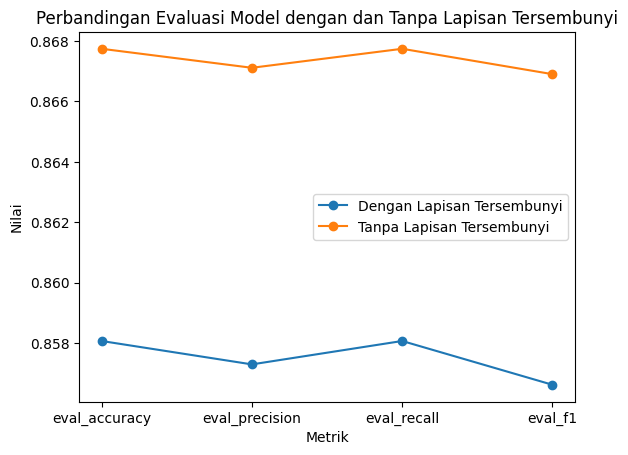

In [27]:
import matplotlib.pyplot as plt

# Metrik yang dievaluasi
metrics = ['eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1']

# Hasil evaluasi untuk kedua model
hidden_metrics = [eval_results_with_hidden.get(metric, None) for metric in metrics]
no_hidden_metrics = [eval_results_without_hidden.get(metric, None) for metric in metrics]

fig, ax = plt.subplots()

# Plot perbandingan
ax.plot(metrics, hidden_metrics, label='Dengan Lapisan Tersembunyi', marker='o')
ax.plot(metrics, no_hidden_metrics, label='Tanpa Lapisan Tersembunyi', marker='o')

ax.set_xlabel('Metrik')
ax.set_ylabel('Nilai')
ax.legend()

plt.title("Perbandingan Evaluasi Model dengan dan Tanpa Lapisan Tersembunyi")
plt.show()

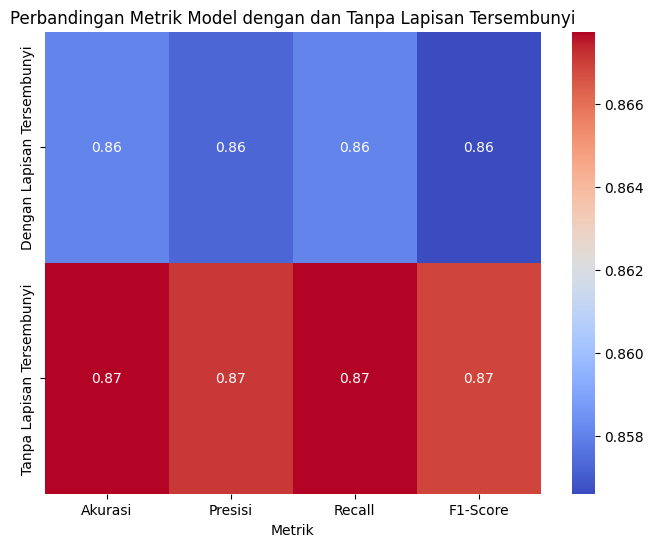

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data untuk heatmap
data = {
    'Metrik': ['Akurasi', 'Presisi', 'Recall', 'F1-Score'],
    'Dengan Lapisan Tersembunyi': hidden_metrics,
    'Tanpa Lapisan Tersembunyi': no_hidden_metrics
}

df = pd.DataFrame(data)

# Membuat heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.set_index('Metrik').T, annot=True, cmap='coolwarm', cbar=True)
plt.title("Perbandingan Metrik Model dengan dan Tanpa Lapisan Tersembunyi")
plt.show()

In [30]:
# Menyimpan model dengan lapisan tersembunyi
model_with_hidden_output_path = './model_with_hidden'
trainer_with_hidden.save_model(model_with_hidden_output_path)  # Menyimpan model
print(f"Model dengan lapisan tersembunyi disimpan di: {model_with_hidden_output_path}")

# Menyimpan model tanpa lapisan tersembunyi
model_without_hidden_output_path = './model_without_hidden'
trainer_without_hidden.save_model(model_without_hidden_output_path)  # Menyimpan model
print(f"Model tanpa lapisan tersembunyi disimpan di: {model_without_hidden_output_path}")

Model dengan lapisan tersembunyi disimpan di: ./model_with_hidden
Model tanpa lapisan tersembunyi disimpan di: ./model_without_hidden
